n_estimators: 50, max_depth: None, min_samples_split: 2, Accuracy: 0.57
n_estimators: 50, max_depth: None, min_samples_split: 5, Accuracy: 0.64
n_estimators: 50, max_depth: None, min_samples_split: 10, Accuracy: 0.79
n_estimators: 50, max_depth: 10, min_samples_split: 2, Accuracy: 0.57
n_estimators: 50, max_depth: 10, min_samples_split: 5, Accuracy: 0.64
n_estimators: 50, max_depth: 10, min_samples_split: 10, Accuracy: 0.79
n_estimators: 50, max_depth: 20, min_samples_split: 2, Accuracy: 0.57
n_estimators: 50, max_depth: 20, min_samples_split: 5, Accuracy: 0.64
n_estimators: 50, max_depth: 20, min_samples_split: 10, Accuracy: 0.79
n_estimators: 50, max_depth: 30, min_samples_split: 2, Accuracy: 0.57
n_estimators: 50, max_depth: 30, min_samples_split: 5, Accuracy: 0.64
n_estimators: 50, max_depth: 30, min_samples_split: 10, Accuracy: 0.79
n_estimators: 100, max_depth: None, min_samples_split: 2, Accuracy: 0.57
n_estimators: 100, max_depth: None, min_samples_split: 5, Accuracy: 0.57
n_es

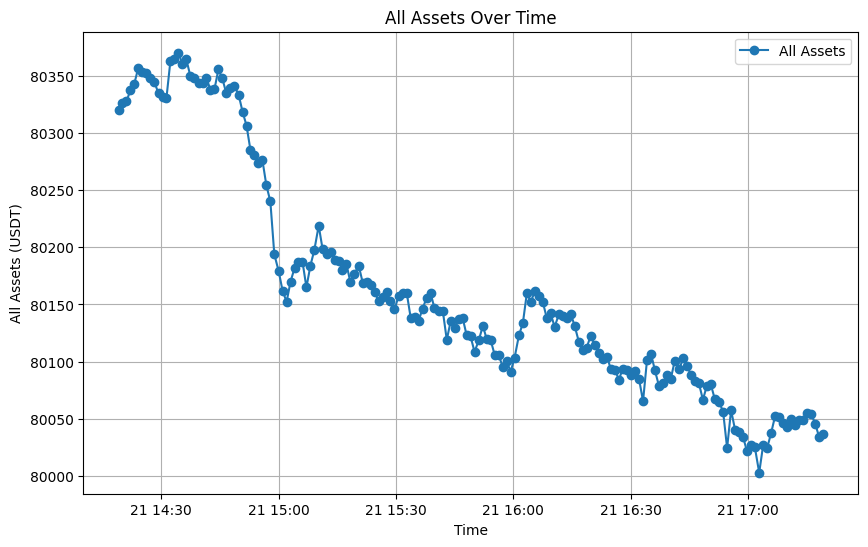

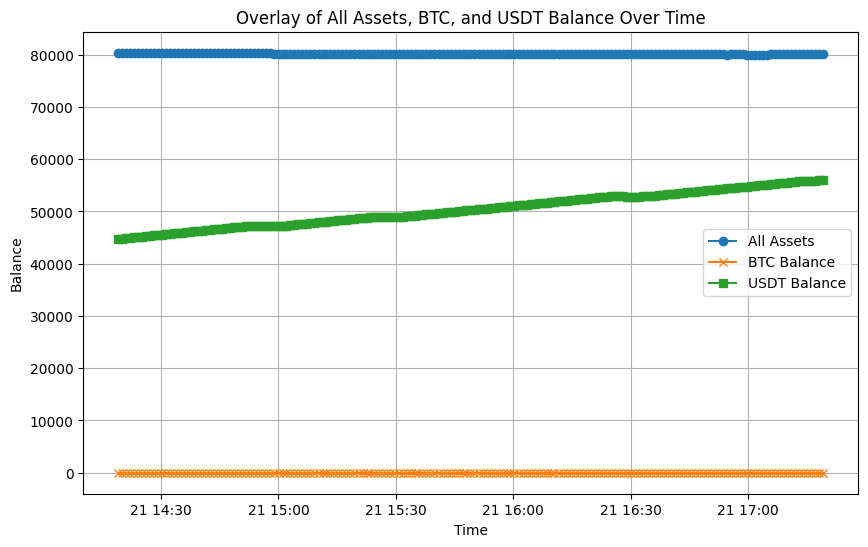

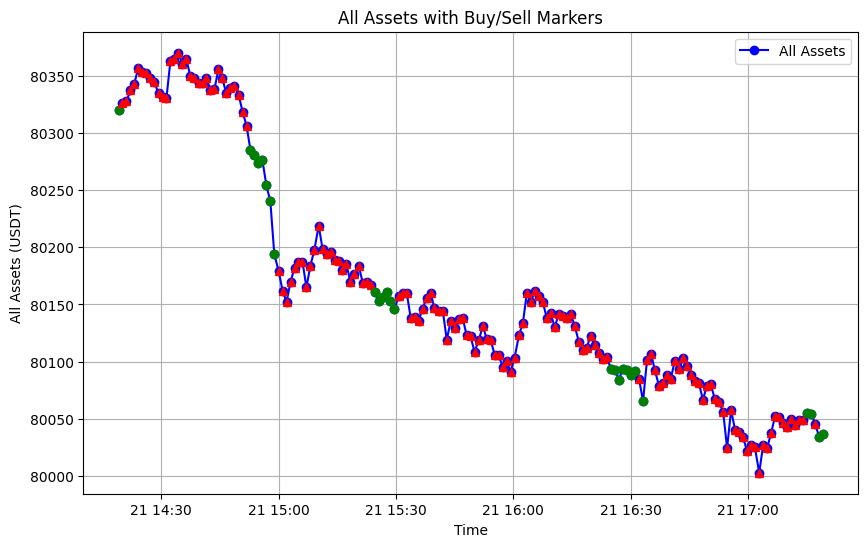

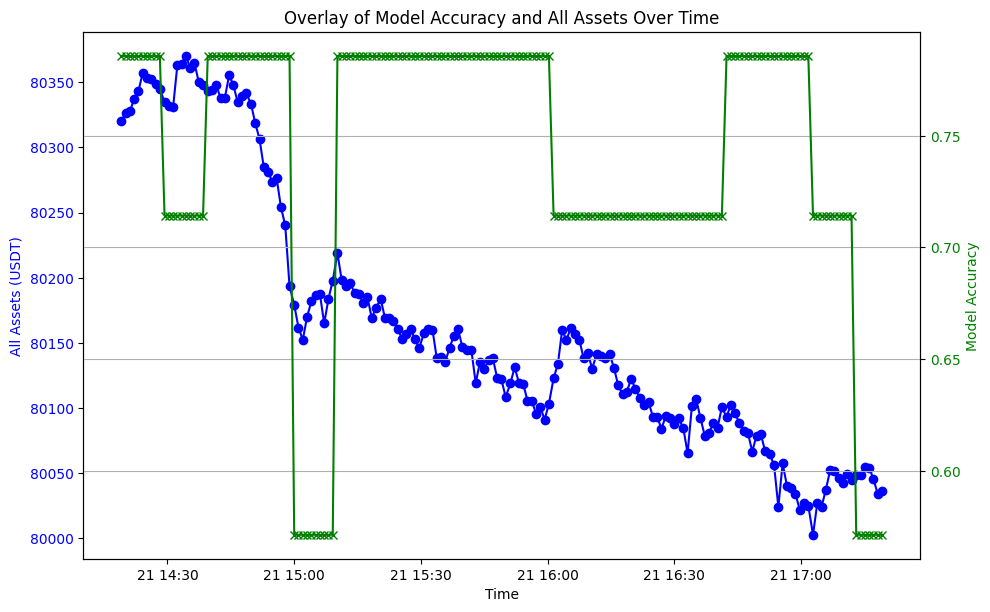

In [11]:
import ccxt
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import ta  # Technical Analysis Library

# 初始化 OKX 交易所，启用 sandbox 模式
okx = ccxt.okx({
    'apiKey': '',
    'secret': '',
    'password': '',
    'enableRateLimit': True,
})

"""隨便你策略怎麼寫，但一定要一定要一定要加這一行，這是使用模擬交易模式-----------------------------------------------------------------------------------------------------------"""

okx.set_sandbox_mode(True)  

"""--------------------------------------------------------------------------------------------------------------------------------------------------------------------"""

symbol = 'BTC/USDT'
timeframe = '1h'

# Initialize a list to store trading log data
trade_log = []

# Fetch historical data
def fetch_ohlcv(symbol, timeframe):
    ohlcv = okx.fetch_ohlcv(symbol, timeframe)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Prepare the dataset with features for Random Forest
def prepare_dataset(df):
    df['returns'] = df['close'].pct_change()  # Percent change in closing price
    df['volatility'] = df['close'].rolling(window=7).std()  # Rolling volatility
    df['ma7'] = df['close'].rolling(window=7).mean()  # MA7
    df['ma21'] = df['close'].rolling(window=21).mean()  # MA21
    df['price_diff'] = df['close'] - df['open']  # Price difference between open and close

    # Add RSI and MACD features
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['macd_diff'] = ta.trend.MACD(df['close']).macd_diff()

    
    
    df.dropna(inplace=True)  # Drop NaNs from rolling calculations
    
    df['signal'] = 0
    df.loc[df['returns'].shift(-1) > 0, 'signal'] = 1  # Buy signal if next return is positive
    df.loc[df['returns'].shift(-1) < 0, 'signal'] = 0  # Sell signal if next return is negative
    

    features = ['returns', 'volatility', 'ma7', 'ma21', 'price_diff', 'rsi', 'macd_diff']
    X = df[features]
    y = df['signal']
    
    return X, y

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Train a Random Forest model with parameter tuning
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()  # Normalize features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Define parameter values to explore
    n_estimators_values = [50, 100, 200, 300]
    max_depth_values = [None, 10, 20, 30]
    min_samples_split_values = [2, 5, 10]

    # Initialize variables to store the best parameters and accuracy
    best_n_estimators = 0
    best_max_depth = 0
    best_min_samples_split = 0
    best_accuracy = 0

    # Loop over all combinations of the three parameters
    for n in n_estimators_values:
        for depth in max_depth_values:
            for split in min_samples_split_values:
                model = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_split=split, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                print(f"n_estimators: {n}, max_depth: {depth}, min_samples_split: {split}, Accuracy: {accuracy:.2f}")
                
                # Update best parameters if current model performs better
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_n_estimators = n
                    best_max_depth = depth
                    best_min_samples_split = split

    # Train the final model with the best parameters
    best_model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
    best_model.fit(X_train, y_train)
    
    print(f"Best Parameters - n_estimators: {best_n_estimators}, max_depth: {best_max_depth}, min_samples_split: {best_min_samples_split}")
    print(f"Best Model Accuracy: {best_accuracy:.2f}")
    
    return best_model, scaler, best_accuracy


# Get the latest signal using Random Forest model
def get_latest_signal(model, scaler, df):
    latest_data = df.tail(1)
    features = ['returns', 'volatility', 'ma7', 'ma21', 'price_diff', 'rsi', 'macd_diff']
    X_latest = scaler.transform(latest_data[features])
    signal = model.predict(X_latest)[0]
    
    if signal == 1:
        return 'buy'
    elif signal == 0:
        return 'sell'
    else:
        return 'hold'

#calculate all estimate assets
def cal_all_assest():
    # Fetch account balance
    balance = okx.fetch_balance()

    # Get total balance in each asset
    assets = balance['total']
    estimated_value = 0.0

    # Fetch USDT price for each asset and calculate the estimated value in USDT
    for asset, amount in assets.items():
        if amount > 0:
            if asset == 'USDT':
                estimated_value += amount  # USDT doesn't need conversion
            else:
                try:
                    # Get market price of asset in USDT
                    ticker = okx.fetch_ticker(f'{asset}/USDT')
                    price_in_usdt = ticker['last']
                    estimated_value += amount * price_in_usdt
                except ccxt.BaseError:
                    # Skip assets that don't have USDT pair
                    print(f"Skipping {asset}, no USDT pair found.")

    # Display the estimated value in USDT
    print(f"Estimated value of all assets in USDT: {estimated_value}")
    return estimated_value



# Record and execute trades with 1-3% of assets
def execute_trade(signal, symbol, trade_log, model_accuracy):
    balance = okx.fetch_balance()
    usdt_balance = balance['total'].get('USDT', 0)
    btc_balance = balance['total'].get('BTC', 0)
    trade_time = pd.Timestamp.now()  # Record the current time of trade action

    # Print current balances for reference
    print(f"Current USDT Balance: {usdt_balance}")
    print(f"Current BTC Balance: {btc_balance}")

    # Define a percentage range for trading (3% to 5%)
    #trade_percentage = random.uniform(0.03, 0.035)

    if signal == 'buy':
        # Buy BTC using 0.01% to 0.02% of USDT balance
        #trade_amount_usdt = usdt_balance * trade_percentage
        trade_amount_usdt = 11
        if trade_amount_usdt > 10:  # Ensure enough USDT to make a trade
            order = okx.create_market_buy_order(symbol, trade_amount_usdt / okx.fetch_ticker(symbol)['last'])
            #print(f"Buying {trade_percentage*100:.2f}% of USDT: {order}")
            print(f"Buying {trade_amount_usdt} of USDT: {order}")
            action = 'buy'
        else:
            print("Not enough USDT to buy.")
            action = 'hold'
    elif signal == 'sell':
        # Sell 0.1% to 0.2% of BTC balance
        #trade_amount_btc = btc_balance * trade_percentage
        trade_amount_btc = 0.0011
        if trade_amount_btc > 0.001:  # Ensure enough BTC to make a trade
            order = okx.create_market_sell_order(symbol, trade_amount_btc)
            #print(f"Selling {trade_percentage*100:.2f}% of BTC: {order}")
            print(f"Selling {trade_amount_btc} of BTC: {order}")
            action = 'sell'
        else:
            print("Not enough BTC to sell.")
            action = 'hold'
    else:
        print("Holding: No action taken.")
        action = 'hold'

    all_assest = cal_all_assest()
    print(f"Current all_assest : {all_assest}")

    # Log the trade details: asset (USDT and BTC), trade action, and time
    trade_log.append({
        'time': trade_time,
        'action': action,
        'usdt_balance': usdt_balance,
        'btc_balance': btc_balance,
        'all_assest': all_assest,
        'model_accuracy': model_accuracy
    })



def plot_trade_log(trade_log):
    df_log = pd.DataFrame(trade_log)

    # 1. Plot all assets vs time
    plt.figure(figsize=(10, 6))
    plt.plot(df_log['time'], df_log['all_assest'], label='All Assets', marker='o')
    plt.xlabel('Time')
    plt.ylabel('All Assets (USDT)')
    plt.title('All Assets Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Overlay all assets, BTC balance, and USDT balance vs time
    plt.figure(figsize=(10, 6))
    plt.plot(df_log['time'], df_log['all_assest'], label='All Assets', marker='o')
    plt.plot(df_log['time'], df_log['btc_balance'], label='BTC Balance', marker='x')
    plt.plot(df_log['time'], df_log['usdt_balance'], label='USDT Balance', marker='s')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.title('Overlay of All Assets, BTC, and USDT Balance Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Plot all assets with markers for buy/sell operations
    plt.figure(figsize=(10, 6))
    plt.plot(df_log['time'], df_log['all_assest'], label='All Assets', marker='o', color='blue')

    # Mark buy/sell operations with specific markers
    for i, row in df_log.iterrows():
        if row['action'] == 'buy':
            plt.plot(row['time'], row['all_assest'], 'go')  # Green dot for buy
        elif row['action'] == 'sell':
            plt.plot(row['time'], row['all_assest'], 'r^')  # Red triangle for sell
        elif row['action'] == 'hold':
            continue  # No marker for hold actions

    plt.xlabel('Time')
    plt.ylabel('All Assets (USDT)')
    plt.title('All Assets with Buy/Sell Markers')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Modify the plot_trade_log to include model accuracy and all assets overlayed
    df_log = pd.DataFrame(trade_log)

    # Plot model accuracy and all assets vs time
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Time')
    ax1.set_ylabel('All Assets (USDT)', color='blue')
    ax1.plot(df_log['time'], df_log['all_assest'], label='All Assets', color='blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Model Accuracy', color='green')  # Set label for the second y-axis
    ax2.plot(df_log['time'], df_log['model_accuracy'], label='Model Accuracy', color='green', marker='x')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.title('Overlay of Model Accuracy and All Assets Over Time')
    plt.grid(True)
    plt.show()

# Main trading loop
def main():
    
    i = 0

    try:
        while True:

            i = (i + 1)%10 #retrain model every 10 min
            if(i == 1):
                df = fetch_ohlcv(symbol, timeframe)
                X, y = prepare_dataset(df)

                model, scaler, model_accuracy = train_model(X, y)

                while(model_accuracy <= 0.5):#if model accuracy <= 0.5, retrain the model
                    time.sleep(60)
                    model, scaler, model_accuracy = train_model(X, y)
                
            df = fetch_ohlcv(symbol, timeframe)
            df = prepare_dataset(df)[0]
            signal = get_latest_signal(model, scaler, df)
            print(f"Latest signal: {signal}")
            execute_trade(signal, symbol, trade_log, model_accuracy)
            time.sleep(60)  # Check every 1 min
            
    except KeyboardInterrupt:
        print("Exiting trading loop...")
        # Plot the trade log when the program is interrupted or ends
        plot_trade_log(trade_log)

if __name__ == "__main__":
    main()
